<a href="https://colab.research.google.com/github/PUC-RecSys-Class/RecSysPUC-2020/blob/master/practicos/pyRecLab_iKNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Práctica de Sistemas Recomendadores: Surprise - iKNN

En este práctico vamos a utilizar la biblioteca de Python Surprise desarrollada por Nicolas Hug,, para aprender sobre Item KNN (Filtrado colaborativo basado en items)


**Profesor**: Denis Parra

**Ayudantes**:  Florencia Ferrer, Álvaro Labarca, Nicolás Sumonte, Jorge Facuse y Pablo Messina.



# Índice

>[Tutorial Surprise iKNN](#scrollTo=NC-ceGb8LRLT)

>[Índice](#scrollTo=2j02H66f87eV)

>[Configuración Inicial](#scrollTo=I63yOG6sK6Lx)

>>[Descargando la información](#scrollTo=9qKTQ2V5VKSX)

>>[Revisar archivos descargados](#scrollTo=liJ3L2kl4g1o)

>>[Cómo ver la información de una o más películas](#scrollTo=jqXxj773Foo8)

>>[Instalar Surprise](#scrollTo=P3K5VPZoGSYX)

>[ItemKNN](#scrollTo=FqgkF0dNMo9c)

>>[Entrenar el modelo](#scrollTo=nyiS5jAydggW)

>>[Prediga el rating que le dará un usuario a un ítem](#scrollTo=c-tasjVmdj9Z)

>>[Genera una lista de n recomendaciones para un usuario e indique qué películas son](#scrollTo=Ka67uLNmdoqD)

>>[Explorar los hiperparámetros del modelo ItemKnn](#scrollTo=or0YkBeF8eeC)



# Configuración Inicial

## Descargando la información

Ejecutar cada celda presionando el botón de **Play** o presionando Ctrl+Enter (Linux y Windows) o Command+Enter (OSX) para descargar las bases de datos.

In [ ]:
!curl -L -o "u1.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 1546k  100 1546k    0     0   614k      0  0:00:02  0:00:02 --:--:--  167M


In [ ]:
!curl -L -o "u1.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  385k  100  385k    0     0   162k      0  0:00:02  0:00:02 --:--:--  758k


In [ ]:
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  230k  100  230k    0     0   169k      0  0:00:01  0:00:01 --:--:--  225M


Los archivos **u1.base** y **u1.test** tienen tuplas {usuario, ítem, rating, timestamp}, que es la información de preferencias de usuarios sobre películas en una muestra del dataset [movielens](https://grouplens.org/datasets/movielens/).

## Revisar archivos descargados

Revisemos cómo es uno de estos archivos:

In [ ]:
import pandas as pd

train_file = pd.read_csv('u1.base', sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

train_file.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [ ]:
train_file[train_file['itemid'] == 1653]

,userid,itemid,rating,timestamp
54444,675,1653,5,889489913


Por otra parte, para obtener información adicional de cada película tal como *título*, *fecha de lanzamient*o, *género*, etc., cargaremos el archivo de items descargado ( *u.item* ) para poder mapear cada identificador de ítem al conjunto de datos que lo describe.
Revisemos el contenido de este archivo.

In [ ]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

info_file = pd.read_csv('u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

info_file.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


El comando `pd.options.display.max_columns = None` permite que la tabla se pueda mostrar completamente de forma horizontal, es decir, que muestre todas sus columnas.

In [ ]:
info_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musica

In [ ]:
info_file.describe()

,video_release_date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,0.0,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.00000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000
mean,NaN,0.001189,0.149227,0.080262,0.024970,0.072533,0.300238,0.064804,0.029727,0.431034,0.01308,0.014269,0.054697,0.033294,0.036266,0.146849,0.060048,0.149227,0.042212,0.016052
std,NaN,0.034473,0.356418,0.271779,0.156081,0.259445,0.458498,0.246253,0.169882,0.495368,0.11365,0.118632,0.227455,0.179456,0.187008,0.354061,0.237646,0.356418,0.201131,0.125714
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Con las funciones `info` y `describe` de ***pandas*** es una buena forma de analizar a grandes rasgos un dataset.

## Cómo ver la información de una o más películas
Para esto se hace 2 pasos, 
1. Determinar los índices de las películas.
2. Pedir a `info_file` las columnas.
3. (Adicional) Indicar alguna columna en específico.

In [ ]:
# Ejemplo de cómo visualizar títulos de películas en base a sus IDs
pelis = [5,4,1]
info_file.loc[pelis]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Para éste código:
1. `pelis = [5,4,1]` indica que queremos las películas cuyo índice son 5, 4 y 1.
2. `info_file.loc[pelis]` el método `loc` permite acceder a esas columna
A continuación se verá cómo obtener una columna en específico. Para esto solo es necesario agregar corchetes y el nombre de la columna.

In [ ]:
info_file.loc[pelis]['title']

movieid
5       Copycat (1995)
4    Get Shorty (1995)
1     Toy Story (1995)
Name: title, dtype: object

## Instalar Surprise

Primero es necesario instalar una librería para realizar recomendaciones. Esta se llama Surprise

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 32.7 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633964 sha256=2e30e3e079da006ad7453255492d674527162c771c020c6c5ba14b5d864aa868
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


Luego necesitamos importar Surprise y numpy, librerías que utilizaremos en este práctico

In [ ]:
import surprise
import numpy as np
from collections import defaultdict

# ItemKNN

Probar método de recomendación basado en **ItemKNN**

Similar a lo que se hizo en el práctico de UserKNN, debemos convertir los datos para que sean soportados por la librería Surprise. 

In [ ]:
from surprise.model_selection import PredefinedKFold
reader = surprise.Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1,5))
data = surprise.Dataset.load_from_folds([("u1.base", "u1.test")], reader=reader)
pkf = PredefinedKFold()
trainset, testset = next(pkf.split(data))

## Entrenar el modelo

Lo primero que se debe hacer es entrenar el modelo, con los datos descargados anteriormente. 

In [ ]:
# Declarar el objeto recomendador ItemKNN
from surprise import accuracy
myItemKnn = surprise.KNNBasic(k=7, sim_options={'name': 'pearson', 'user_based': False})

Se puede ver que al objeto recomendador le estamos entregando:
* ***k***: La cantidad de vecinos que se considerarán.
* ***sim_options:*** Diccionario que contiene los detalles de la función de similaridad que se usará. Dentro de este, definimos:
  * ***name:*** La función de similitud. Puede ser Pearson, Cosine, etc.
  * ***user_based:*** Booleano que define si el método será basado en usuarios o items.

In [ ]:
# Entrenamos el modelo con los datos existentes usando la función fit del objeto recomendador.

myItemKnn.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


## Prediga el rating que le dará un usuario a un ítem

model_name.predict("user_id", "item_id")

In [ ]:
myItemKnn.predict("457", "37")

Prediction(uid='457', iid='37', r_ui=None, est=4.571428571428571, details={'actual_k': 7, 'was_impossible': False})

## Genera una lista de recomendaciones para un usuario

Generar lista de 10 recomendaciones para el usuario con ID 457. Indique qué películas son con todas sus columnas. (Recuerde el comando loc vista anteriormete)

Como se explicó en la ayudantía de UserKNN, para obtener las predicciones de una lista de elementos, se debe llamar a la función ***.test()*** de el objeto recomendador. Sin embargo, esta función solo recibe objetos del tipo testset de la misma librería.

Para esto, se usa la función ***.build_anti_testset()*** a partir de un objeto trainset que entrega un objeto ***testset*** con todos los pares usuario-item que no tengan un valor fijado en el trainset.

In [ ]:
a_testset = trainset.build_anti_testset()
predictions = myItemKnn.test(a_testset)

Luego, usamos la función ***get_top_n*** sugerida en la [documentación](https://surprise.readthedocs.io/en/stable/FAQ.html) la cual recibe todas las predicciones para cada item-usuario desconocido (que tenemos guardado en la variable ***predictions***) y retorna un diccionario que recibe de llave el *id* de un usuario y retorna una lista de tuplas con el id de los items recomendados y su rating predicho.

In [ ]:
def get_top_n(predictions, n=10):
    """Devuelve las N-mejores recomendaciones para cada usuario de un set de predicción.

    Args:
        predictions(lista de objetos Prediction): La lista de predicción obtenida del método test.
        n(int): El número de recomendaciónes por usuario

    Returns:
    Un diccionario donde las llaves son ids de usuario y los valores son listas de tuplas:
        [(item id, rating estimation), ...] de tamaño n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
top_n = get_top_n(predictions, n=10)
print(top_n["457"])

[('668', 5), ('970', 5), ('1238', 5), ('1306', 5), ('1429', 5), ('1464', 5), ('1652', 5), ('1431', 5), ('460', 4.857142857142857), ('1104', 4.857142857142857)]


In [ ]:
info_file.loc[[int(m[0]) for m in top_n["457"]]]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
668,Blood Beach (1981),01-Jan-1981,NaN,http://us.imdb.com/M/title-exact?Blood%20Beach...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
970,Hear My Song (1991),01-Jan-1991,NaN,http://us.imdb.com/M/title-exact?Hear%20My%20S...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1238,Full Speed (1996),01-Jan-1996,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1306,Delta of Venus (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Delta%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1429,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1464,"Stars Fell on Henrietta, The (1995)",01-Jan-1995,NaN,http://us.imdb.com/Title?Stars+Fell+on+Henriet...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1652,Temptress Moon (Feng Yue) (1996),13-Jun-1997,NaN,http://us.imdb.com/M/title-exact?Feng%20Yue%20...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1431,Legal Deceit (1997),01-Jan-1997,NaN,http://us.imdb.com/Title?Legal+Deceit+(1997),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
460,"Crossing Guard, The (1995)",01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Crossing%20Gu...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## Explorar los hiperparámetros del modelo ***ItemKnn***

Uno de los parámetros que vamos a explorar es el número de vecinos escogidos (Items), para esto calculamos el error del modelo con varios valores de vecinos y observamos cómo es el comportamiento del error. 

In [ ]:
k_values = [5, 10, 30, 50, 70, 100] # definir distintos valores de vecinos (k)
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for k in k_values:
  myItemKnn = surprise.KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': False})
  myItemKnn.fit(trainset)
  predictions = myItemKnn.test(testset)
  rmse_values.append(accuracy.rmse(predictions))
  mae_values.append(accuracy.mae(predictions))

print('RMSE:', rmse_values)
print('MAE:', mae_values)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1904
MAE:  0.9387
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1081
MAE:  0.8727
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0468
MAE:  0.8240
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0363
MAE:  0.8167
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0342
MAE:  0.8172
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0358
MAE:  0.8220
RMSE: [1.1904297733071172, 1.1080667730007354, 1.0467585478864254, 1.0363002520688176, 1.0341856080559526, 1.0358053497178856]
MAE: [0.9387469705356998, 0.8726576275881789, 0.8240157590550622, 0.8166952110756726, 0.8172141331963237, 0.8220366717443632]


### Evaluar en base a error de prediccion (RMSE y MAE)

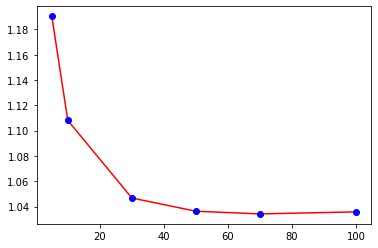

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, rmse_values, 'r-')
plt.plot(k_values, rmse_values, 'bo')
plt.show()

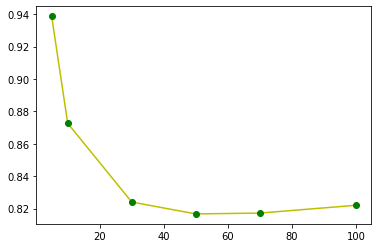

In [ ]:
plt.plot(k_values, mae_values, 'y-')
plt.plot(k_values, mae_values, 'go')
plt.show()



Según los resultados: ¿Qué número de vecinos es mejor para hacer recomendaciones con un menor error de predicción?

El mejor número de vecinos es aquel con el que se obtiene el menor error, por ende podría ser 50 o 70, dependiendo el error que consideramos. 

In [ ]:
myItemKnn = surprise.KNNBasic(k=70, sim_options={'name': 'cosine', 'user_based': False})
myItemKnn.fit(trainset)
predictions = myItemKnn.test(a_testset)
top_n = get_top_n(predictions, n=10)
print(top_n["457"])
pelis_userKnn = np.array([m[0] for m in top_n["457"]]).astype(int)
info_file.loc[pelis_userKnn]['title']

Computing the cosine similarity matrix...
Done computing similarity matrix.
[('1156', 4.6), ('1422', 4.578947368421052), ('483', 4.557586119678931), ('188', 4.55724128055209), ('56', 4.557185844730653), ('1201', 4.555555555555555), ('12', 4.544291556172183), ('357', 4.543683064992804), ('173', 4.54344451102902), ('168', 4.542994534547152)]


movieid
1156                                  Cyclo (1995)
1422                                 Suture (1993)
483                              Casablanca (1942)
188                       Full Metal Jacket (1987)
56                             Pulp Fiction (1994)
1201    Marlene Dietrich: Shadow and Light (1996) 
12                      Usual Suspects, The (1995)
357         One Flew Over the Cuckoo's Nest (1975)
173                     Princess Bride, The (1987)
168         Monty Python and the Holy Grail (1974)
Name: title, dtype: object

In [ ]:
myItemKnn = surprise.KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': False})
myItemKnn.fit(trainset)
predictions = myItemKnn.test(a_testset)
top_n = get_top_n(predictions, n=10)
print(top_n["457"])
pelis_userKnn = np.array([m[0] for m in top_n["457"]]).astype(int)
info_file.loc[pelis_userKnn]['title']

Computing the cosine similarity matrix...
Done computing similarity matrix.
[('12', 4.6606856436717194), ('64', 4.640536619891128), ('296', 4.64), ('1156', 4.6), ('1319', 4.6), ('1344', 4.6), ('1560', 4.6), ('1682', 4.6), ('127', 4.599850162107938), ('188', 4.5995370630611845)]


movieid
12                     Usual Suspects, The (1995)
64               Shawshank Redemption, The (1994)
296                           Promesse, La (1996)
1156                                 Cyclo (1995)
1319                       Neon Bible, The (1995)
1344                 Story of Xinghua, The (1993)
1560         Clean Slate (Coup de Torchon) (1981)
1682    Scream of Stone (Schrei aus Stein) (1991)
127                         Godfather, The (1972)
188                      Full Metal Jacket (1987)
Name: title, dtype: object